# Прогнозирование качества вина с использованием нейронных сетей

## Описание проекта
Этот проект разработан для предсказания качества красного вина (оценка от 0 до 10) на основе его физико-химических характеристик. Используется нейронная сеть с регуляризацией и техниками для борьбы с переобучением.

## Загрузка и анализ данных

In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GaussianDropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler

In [3]:
# Загрузка данных о качестве красного вина
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# Просмотр первых строк данных
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


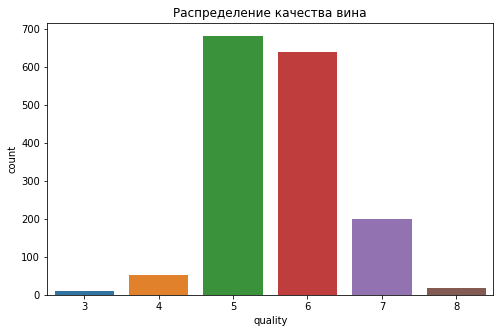

In [5]:
# Анализ распределения целевой переменной (quality)
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=data)
plt.title('Распределение качества вина')
plt.show()

По распределению качества вина видно, что больше всего сортов вин с качеством = 5, меньше всего - с качеством = 3

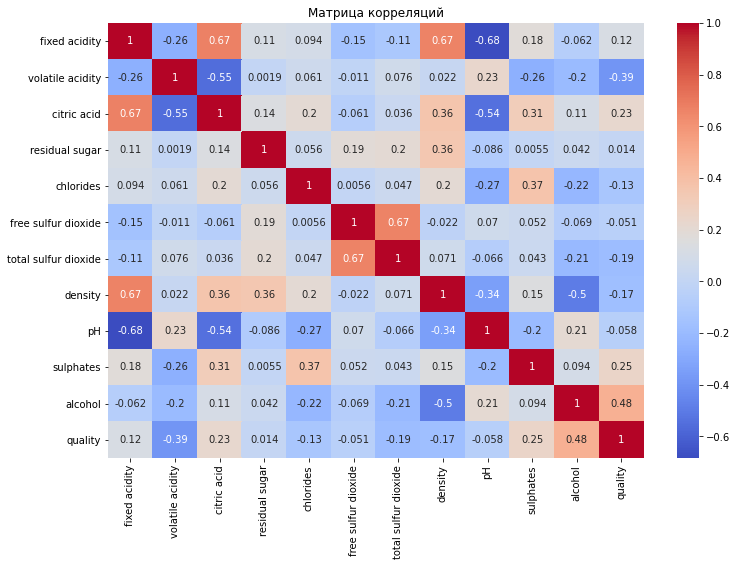

In [6]:
# Анализ корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

Сильнее всего корреллируют значения признаков citric acid и fixed acidity (0.67)

Фиксированная кислотность (fixed acidity) — это суммарный показатель всех кислот в вине, лимонная кислота (citric acid) - это одна из органических кислот, входящих в состав вина наряду с винной, яблочной и другими.

Корреляция 0.67 означает, что лимонная кислота вносит значимый вклад в общую кислотность, но не является единственным её компонентом.

In [7]:
# Проверка на пропущенные значения
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Пропущенные значения не обнаружены.

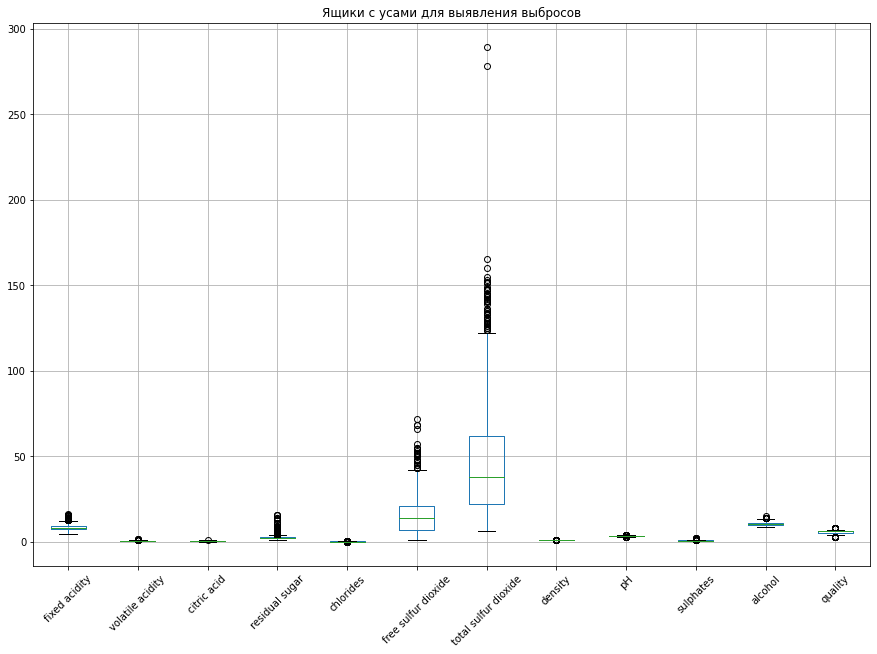

In [9]:
# Анализ выбросов
plt.figure(figsize=(15, 10))
data.boxplot()
plt.xticks(rotation=45)
plt.title('Ящики с усами для выявления выбросов')
plt.show()

У признаков free sulfur dioxide и total sulfur dioxide аномально высокие выбросы, множество точек выше верхнего "уса" (особенно у total sulfur dioxide).

Изучив информацию про содержание диоксида серы в винах, пришла к выводу:

    - для сухих вин (residual sugar < 10)  free sulfur dioxide должен быть больше 1 и меньше 60 (риск серного привкуса), а total sulfur dioxide должен быть больше 10 и меньше 200;
    - для сладких вин (residual sugar >= 10) free sulfur dioxide должно быть больше 150, а total sulfur dioxide должно быть меньше 400;

## Предобработка данных

In [10]:
def remove_scientific_outliers(data):
    limits = {
        'fixed acidity': (4.0, 12.0),
        'volatile acidity': (0.1, 1.2),
        'citric acid': (0.0, 1.0),
        'residual sugar': (0.5, 30.0),
        'chlorides': (0.01, 0.2),
        'free sulfur dioxide': (1, 100),
        'total sulfur dioxide': (10, 200),
        'density': (0.98, 1.05),
        'pH': (2.8, 4.0),
        'sulphates': (0.3, 1.5),
        'alcohol': (8.0, 15.0)
    }
    for feature, (min_val, max_val) in limits.items():
        data = data[(data[feature] >= min_val) & (data[feature] <= max_val)]
    return data

In [11]:
remove_scientific_outliers(data)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Создание новых признаков

In [12]:
data['acid_ratio'] = data['citric acid'] / (data['volatile acidity'] + 1e-6)
data['sulfur_balance'] = data['free sulfur dioxide'] / (data['total sulfur dioxide'] + 1e-6)
data['alcohol_to_acid'] = data['alcohol'] / (data['fixed acidity'] + 1e-6)

### Разделение на признаки и целевую переменную

In [32]:
X = data.drop('quality', axis=1)
y = data['quality']

### Балансировка данных (для редких классов качества)

In [33]:
smote = SMOTE(k_neighbors=3)
X, y = smote.fit_resample(X, y)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### Разделение на обучающую и тестовую выборки

In [15]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Нормализация данных

In [16]:
# Нормализация данных
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Создание и обучение модели

### Создание модели

In [20]:
model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(l1=0.005, l2=0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l2=0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])

# Компиляция модели
optimizer = Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=True
    )
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Ранняя остановка
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

2025-06-26 16:23:44.048906: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
41/41 [==============================] - 2s 12ms/step - loss: 47.3667 - mae: 5.8425 - val_loss: 43.3011 - val_mae: 5.5740 - lr: 1.0000e-04
Epoch 2/100
41/41 [==============================] - 0s 7ms/step - loss: 44.8707 - mae: 5.6609 - val_loss: 42.1037 - val_mae: 5.4814 - lr: 1.0000e-04
Epoch 3/100
41/41 [==============================] - 0s 6ms/step - loss: 41.8281 - mae: 5.4361 - val_loss: 40.6849 - val_mae: 5.3692 - lr: 1.0000e-04
Epoch 4/100
41/41 [==============================] - 0s 6ms/step - loss: 39.6265 - mae: 5.2628 - val_loss: 39.0355 - val_mae: 5.2356 - lr: 1.0000e-04
Epoch 5/100
41/41 [==============================] - 0s 7ms/step - loss: 36.9951 - mae: 5.0409 - val_loss: 37.0096 - val_mae: 5.0631 - lr: 1.0000e-04
Epoch 6/100
41/41 [==============================] - 0s 6ms/step - loss: 34.6904 - mae: 4.8260 - val_loss: 34.5979 - val_mae: 4.8492 - lr: 1.0000e-04
Epoch 7/100
41/41 [==============================] - 0s 7ms/step - loss: 32.3392 - mae: 4.5963 - va

### Обучение модели

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

### Интерпретация результатов

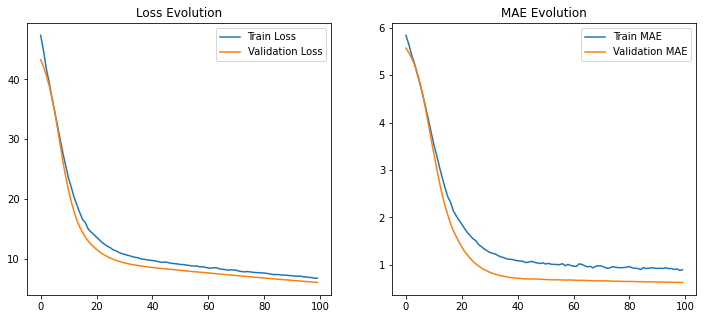

In [21]:
# Графики потерь
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Evolution')
plt.legend()
plt.show()

In [34]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    # Метрики
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")

evaluate_model(model, X_test, y_test)
# Интерпретация результатов
if r2 > 0.6:
    print("Отличный результат! Модель хорошо объясняет вариативность данных.")
elif r2 > 0.4:
    print("Хороший результат. Есть потенциал для улучшений.")
else:
    print("Результат требует доработки. Рекомендуется:")
    print("- Добавить больше признаков")
    print("- Попробовать другие алгоритмы (например, Gradient Boosting)")
    print("- Увеличить размер выборки")

R² Score: 0.7782
MAE: 0.6310
Отличный результат! Модель хорошо объясняет вариативность данных.


### График предсказаний vs реальных значений

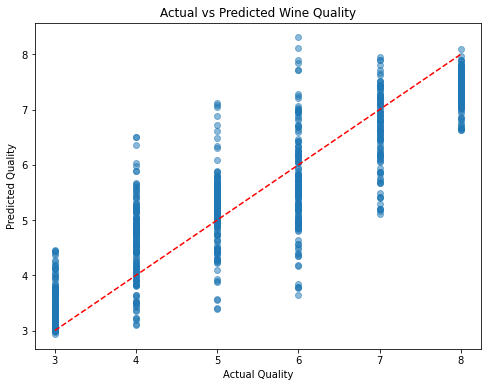

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.title('Actual vs Predicted Wine Quality')
plt.show()

## Итоги

- Загрузка и анализ данных

    - Загрузка данных из UCI Machine Learning Repository

    - Визуализация распределения целевой переменной

    - Анализ корреляций между признаками

    - Проверка на выбросы

- Предобработка данных

    - Удаление выбросов на основе научных границ

    - Создание новых признаков:

        - acid_ratio - баланс кислот

        - sulfur_balance - соотношение SO₂

        - alcohol_to_acid - отношение алкоголя к кислотности

    - Балансировка данных с помощью SMOTE

    - Нормализация с использованием RobustScaler

- Построение модели

    - Архитектура нейронной сети:

         - 3 скрытых слоя (128-64-32 нейрона)

         - BatchNormalization и Dropout для регуляризации

         - L1/L2 регуляризация

    - Оптимизатор Adam с динамическим learning rate

    - Callbacks:

        - EarlyStopping

        - ReduceLROnPlateau

- Оценка модели

    - Метрики:

        - R² (коэффициент детерминации)

        - MAE (средняя абсолютная ошибка)

    - Визуализация:

        - Графики обучения (loss/MAE)

        - Сравнение предсказаний с реальными значениями

## Рекомендации по улучшению

1) Добавьте больше признаков (например, сорт винограда);

2) Попробуйте другие алгоритмы (Gradient Boosting);

3) Увеличьте размер выборки;

4) Экспериментируйте с архитектурой сети.